In [18]:
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

### collective datasets analysis

In [49]:
KPI_data = {os.path.splitext(os.path.basename(file_name))[0] : pd.read_csv(file_name) for file_name in glob.glob('original_data/*')}
for dataset_name in KPI_data:
    print(dataset_name, KPI_data[dataset_name].columns[-1])

child_mortality_0_5_year_olds_dying_per_1000_born 2100
coal_consumption_per_cap 2019
sh_med_beds_zs 2019
underweight_children 2008


In [50]:
# the inner join of the country name in all datasets
dataset_country_name = [set(KPI_data[_].country) for _ in KPI_data]
print(dataset_country_name[0].intersection(*dataset_country_name[1:]))

{'Turkey', 'Colombia', 'Oman', 'Singapore', 'Uzbekistan', 'North Macedonia', 'Sri Lanka', 'Ukraine', 'Chile', 'Morocco', 'India', 'Azerbaijan', 'Czech Republic', 'Kazakhstan', 'Egypt', 'China', 'Bangladesh', 'Germany', 'Thailand', 'Ecuador', 'Belarus', 'Peru', 'Iraq', 'Argentina', 'Hungary', 'Netherlands', 'Algeria', 'Vietnam', 'Trinidad and Tobago', 'Bulgaria', 'Romania', 'Pakistan', 'Philippines', 'Saudi Arabia', 'Brazil', 'Mexico', 'United States', 'Indonesia'}


### Ploting gpd map

In [21]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [39]:
def plot_global_map(df: pd.DataFrame, year: str):
    fig, ax = plt.subplots(figsize=(20, 10))
    df.plot(column=year, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    vmin = df[year].min()
    vmax = df[year].max()
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.title(year)
    plt.tight_layout()
    plt.colorbar(sm)

In [52]:
# loading dataframe 
child_mortality = pd.read_csv("original_data\child_mortality_0_5_year_olds_dying_per_1000_born.csv")

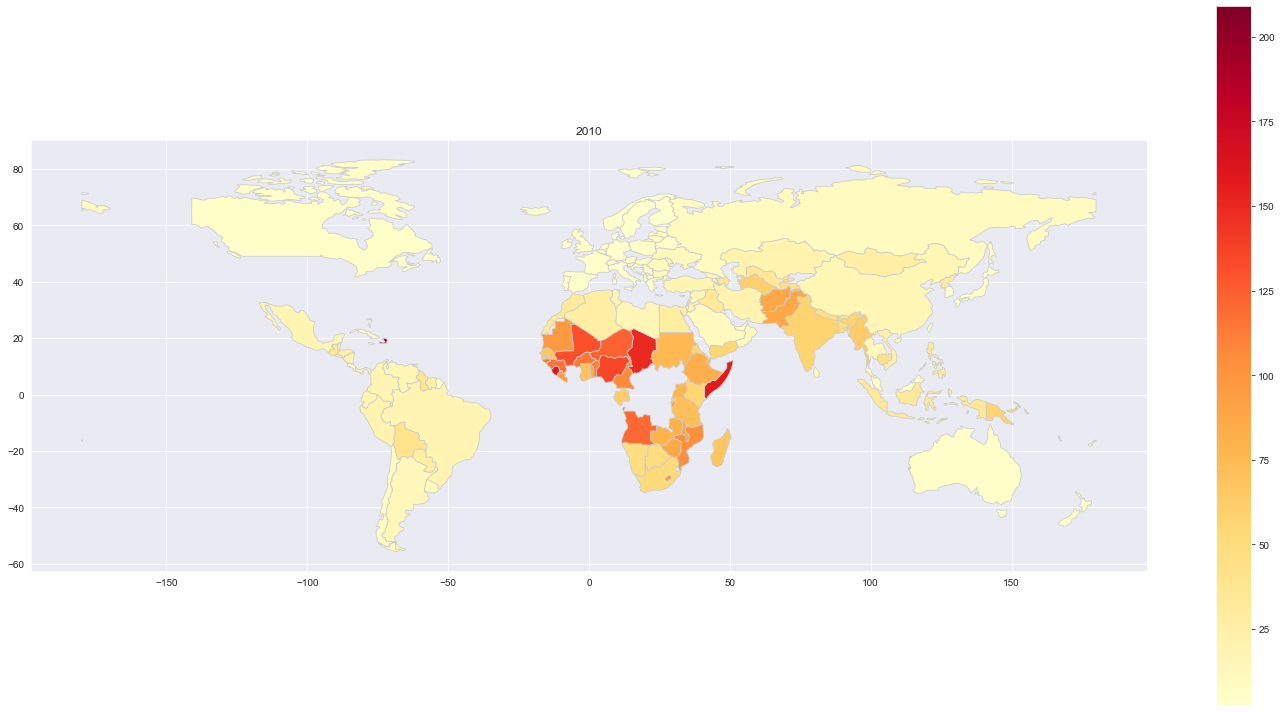

In [53]:
gpd_child_mortality = countries.set_index('name').join(child_mortality.set_index('country'))
plot_global_map(gpd_child_mortality, '2010')